# *ECS7020P mini-project submission*

***Krishna Sameer***

***Student ID: 210470013***


Basic solution [Brief Summary][6 marks]: Using the MLEnd dataset, I built a model that predicts the intonation of a short audio segment and tried different models and hyperparameters for getting high accuracy.

# Environment set up



In [ ]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Import seaborn
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import sklearn

In [ ]:
path = '/content/drive/MyDrive/Data/MLEnd'
os.listdir(path)

['trainingMLEnd.csv', 'training.zip', 'training']

# Data download

In this section we will download the data that you need to build your solutions. Note that even though we call it "training" dataset you can do whatever you want with it, for instance validation tasks. Note that we keep a separate dataset for testing purposes, which we won't share with anyone.

First, we will define a function that will allow us to download a file into a chosen location.

In [ ]:
#def download_url(url, save_path):
#    with urllib.request.urlopen(url) as dl_file:
#        with open(save_path, 'wb') as out_file:
#            out_file.write(dl_file.read())

In [ ]:
#url  = "https://collect.qmul.ac.uk/down?t=6H8231DQL1NGDI9A/613DLM2R3OFV5EEH9INK2OG"
#save_path = '/content/drive/MyDrive/Data/MLEnd/training.zip'
#download_url(url, save_path)

In [ ]:
#directory_to_extract_to = '/content/drive/MyDrive/Data/MLEnd/training/'
#with zipfile.ZipFile(save_path, 'r') as zip_ref:
#    zip_ref.extractall(directory_to_extract_to)

# Exploratory Data Analysis




Let's check how many audio files we have in our training dataset:

In [ ]:
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files) 

20000

This figure (20k) corresponds to the number of **items** or **samples** in our dataset. Let's listen to some random audio files:

In [ ]:
# five random files
for _ in range(5):
  n = np.random.randint(20000)
  display(ipd.Audio(files[n]))

In [ ]:
# Loading the csv file
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv') 
labels

,File ID,digit_label,participant,intonation
0,0000000.wav,4,S73,question
1,0000001.wav,2,S88,excited
2,0000002.wav,70,S5,neutral
3,0000003.wav,2,S85,bored
4,0000004.wav,4,S30,excited
...,...,...,...,...
19995,0019995.wav,90,S163,excited
19996,0019996.wav,10,S99,question
19997,0019997.wav,90,S46,question
19998,0019998.wav,19,S13,neutral


***Number of samples per numerals***

,digit_label,counts
0,0,655
1,1,663
2,2,652
3,3,650
4,4,641
5,5,650
6,6,668
7,7,638
8,8,653
9,9,663


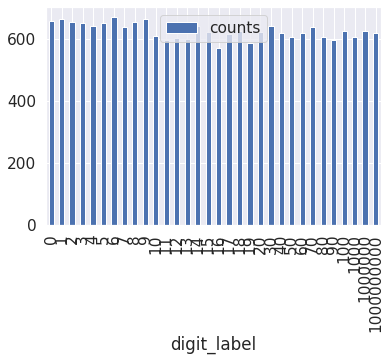

In [ ]:
#Numerals Count and Histogram
df_numerals = labels.groupby('digit_label').size().reset_index(name='counts')
display(df_numerals)
graph1 = df_numerals.plot.bar(x='digit_label', y='counts')

***Number of samples per Participant***

In [ ]:
Participant = labels["participant"].value_counts().to_frame() # Counting the number of participants 
print("Number of samples per Participant: \n\n" , Participant)

print("Shape: \n\n" ,Participant.shape)
print("\n\n Statistics: \n\n", Participant.describe())

***Number of samples per Intonation***

Number of samples per Intonation: 

           intonation
question        5000
excited         5000
neutral         5000
bored           5000


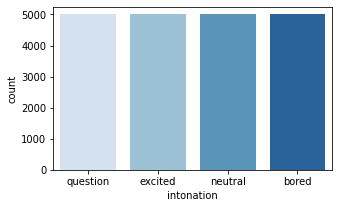

In [ ]:
Intonation = labels["intonation"].value_counts().to_frame() # Counting the number of samples per intonations
print("Number of samples per Intonation: \n\n" , Intonation)

plt.figure(figsize=(5,3))
sns.countplot(x="intonation", data=labels, palette="Blues")

plt.show()

# Feature Extraction: Pitch


Audio files are complex data types. Specifically they are **discrete signals** or **time series**, consisting of values on a 1D grid. These values are known as *samples* themselves, which might be a bit confusing, as we have used this term to refer to the *items* in our dataset. The **sampling frequency** is the rate at which samples in an audio file are produced. For instance a sampling frequency of 5HZ indicates that 5 produce 5 samples per second, or 1 sample every 0.2 s.

Let's plot one of our audio signals:

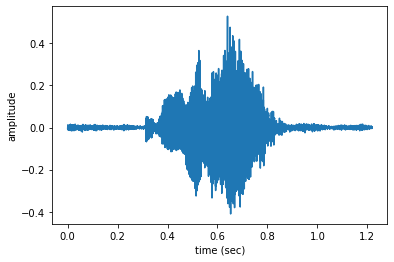

In [ ]:
#Plotting the visualization of an audio sample

n=0
fs = None # Sampling frequency. If None, fs would be 22050
x, fs = librosa.load(files[n],sr=fs)
t = np.arange(len(x))/fs
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(files[n]))

The file that we are listening to is:

In [ ]:
files[n]

'/content/drive/MyDrive/Data/MLEnd/training/Training/0006970.wav'

In [ ]:
n=0
x, fs = librosa.load(files[n],sr=fs)
print('This audio signal has', len(x), 'samples')

This audio signal has 26880 samples


In [ ]:
# Data Normalization
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)


One approach is to extract a few features from our signals and use these features instead as predictors. In the following cell, we define a function that extracts four features from an audio signal, namely:


1.   Power.
2.   Pitch mean.
3.   Pitch standard deviation.
4.   Fraction of voiced region.

In the next cell, we define a new function that gets the pitch of an audio signal.

In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

**Model to predict the intonations taking audio data as input.**

In [ ]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]
  for file in tqdm(files):
    fileID = file.split('/')[-1]
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    label = list(labels_file[labels_file['File ID']==fileID]['intonation'])[0]
    if onlySingleDigit and yi>9:
      continue
    else:
      fs = None # if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio: x = x/np.max(np.abs(x))
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(label)
  return np.array(X),np.array(y)

## **Data PreProcessing**

Apply `getXy` to the first 500 files. Note that the first 500 files contains numerals outside the [0, 9] range, which we will be discarding.

In [ ]:
X,y = getXy(files[:500],labels_file=labels,scale_audio=True, onlySingleDigit=True)


Shape of `X` and `y` and prints the labels vector `y`:

In [ ]:
print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
print('The labels vector is', y)

Finally, to be on the cautious side, let's eliminate any potential item with a NaN (*not a number*).

In [ ]:
# If nan sample, remove them
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

0


# Modeling: Support Vector Machines

*Splitting the data to 80-20.*

*80% training 20 % testing*

We will use the SVM method provided by `scikit-learn` and will split the dataset defined by `X` and `y` into a training set and a validation set.

In [ ]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2)
print(X_train.shape, X_val.shape)
print(y_train.shape, y_val.shape)

(125, 4) (32, 4)
(125,) (32,)


Fitting the SVM Model
Showing Result of Training & Validating Accuracy

In [ ]:
from sklearn.model_selection import cross_validate
model  = svm.SVC(C=2)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.456
Validation  Accuracy 0.34375


In [ ]:
# Observation: Increasing the training and validation accuracy
mean = X_train.mean(0)
sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

model  = svm.SVC(C=4,gamma=0.1)
model.fit(X_train,y_train)

yt_p = model.predict(X_train)
yv_p = model.predict(X_val)

print('Training Accuracy', np.mean(yt_p==y_train))
print('Validation  Accuracy', np.mean(yv_p==y_val))

Training Accuracy 0.6
Validation  Accuracy 0.59375


*Comparing different models like GaussianNB, DecisionTreeClassifier, KneighboursClassifier, RandomForestClassifier, QuadraticDiscriminantAnalyser, AdaBoostClassifier with SVC model (kernel = RBF). Finding the best model with higher accuracy*


In [ ]:
mean = X_train.mean(0)

sd =  X_train.std(0)


from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC


X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

classification_models = [
                         GaussianNB(),
                         DecisionTreeClassifier(),
                         KNeighborsClassifier(),
                         RandomForestClassifier(),
                         SVC(kernel='rbf'),
                         AdaBoostClassifier(),
                         QuadraticDiscriminantAnalysis()
]
scores = []
for model in classification_models:
  model.fit(X_train,y_train)
  score=model.score(X_val,y_val)
  model_name=type(model).__name__
  if model_name=='SVC' and model.kernel=='rbf': model_name='RBF kernel'
  scores.append((model_name,(f'{100*score:.2f}%')))
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by = 'Accuracy Score',axis = 0, ascending = False)

,Classifier,Accuracy Score
0,GaussianNB,59.38%
4,RBF kernel,53.12%
6,QuadraticDiscriminantAnalysis,53.12%
2,KNeighborsClassifier,50.00%
1,DecisionTreeClassifier,46.88%
3,RandomForestClassifier,46.88%
5,AdaBoostClassifier,37.50%


**Observations**: It is observed that GaussianNB has the better validation accuracy among all the models. 

**Using Cross_validation to compare accuracy**

In [ ]:
list1 = []
list2 = []
for model in classification_models:
  cv_results = cross_validate(model, X, y, cv=10)
  model_name=type(model).__name__
  print(model_name)
  #print(cv_results['test_score'])
  a = np.average(cv_results['test_score'])
  list1.append(model_name)
  list2.append(a)
  print(a)
df_crossvalidate = pd.DataFrame(data = list2,index = list1,columns=['Accuracy'] )
a = df_crossvalidate.sort_values(by = 'Accuracy',axis = 0, ascending = False)
display(a)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


GaussianNB
0.068
DecisionTreeClassifier
0.052000000000000005
KNeighborsClassifier
0.04000000000000001
RandomForestClassifier
0.05


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


SVC
0.054000000000000006


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


AdaBoostClassifier
0.05600000000000001
QuadraticDiscriminantAnalysis
0.064


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


,Accuracy
GaussianNB,0.068
QuadraticDiscriminantAnalysis,0.064
AdaBoostClassifier,0.056
SVC,0.054
DecisionTreeClassifier,0.052
RandomForestClassifier,0.050
KNeighborsClassifier,0.040


**Observations:** *For training data, GaussianNB gives an accuracy of `59.38%` and after using Cross_Validation the accuracy observed of QuadraticDiscriminantAnalysis is better than GaussianNB.* 


 **Grid Search CV**

This section focuses on: 

 
*   Finding the best value of C and gamma value for SVC 
*   Creating a Confusion Matrix
*   Creating a Confusion Matrix
*   Plotting a heatmap
*   Classification Report

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import seaborn as sn

# Defining the C value, Gamma and kernel
param_grid = { 'C':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7,8,9,10,11],'kernel': ['rbf'],'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,4,5,6,7]}
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)

# Printing the best parameter value
print("Best Parameter Value: \n\n", grid.best_params_)
grid_predictions=grid.predict(X_val)



Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.2, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.2, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.2, kernel=rbf ....................................
[CV] ........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=4, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=5, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=5, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=6, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=6, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=6, kernel=rbf ......................................
[CV] .

[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed:    5.8s finished


**Observations:** Having C = 0.6 & Gama = 0.2 gives the best value

              precision    recall  f1-score   support

       bored       1.00      0.22      0.36         9
     excited       0.43      0.60      0.50         5
     neutral       0.41      0.78      0.54         9
    question       1.00      0.67      0.80         9

    accuracy                           0.56        32
   macro avg       0.71      0.57      0.55        32
weighted avg       0.75      0.56      0.56        32



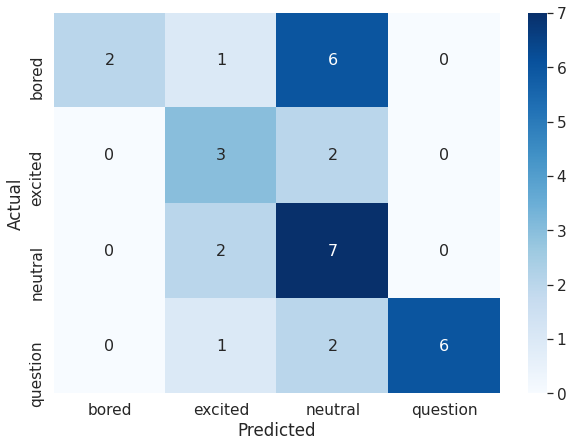

In [ ]:
# Printing the confusion matrix
con_mat = confusion_matrix(y_val,grid_predictions)

# Printing the Classification Report
print(classification_report(y_val,grid_predictions))
df_cm = pd.DataFrame(con_mat, columns=np.unique(y_val), index = np.unique(y_val))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [ ]:
val1=[]
for j in range(len(df_cm.index)):
  list2.append(df_cm.index[j])

In [ ]:
val1=[]
for i in range(4):
  value=(df_cm.iloc[i][i]/df_cm.iloc[i].sum())*100
  list1.append(value)

In [ ]:
df=pd.DataFrame(data = list1,index  = list2,columns=['Accuracy'])
df

,Accuracy
bored,22.222222
excited,60.000000
neutral,77.777778
question,66.666667


**Comparing Results for the best value of C and Gama**

For different values of C in SVC with gamma = 2 

*   Use widget to display all different results in different tabs.
*   plotting the training & validation accuracy.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.424
Validation  Accuracy 0.25
Confusion matrix for Training:
 [[ 0 17 10  0]
 [ 0 32  2  0]
 [ 0 13 21  0]
 [ 0 28  2  0]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 3 2 0]
 [0 4 5 0]
 [0 7 2 0]]

Normalised confusion matrix for Training:
 [[0.         0.62962963 0.37037037 0.        ]
 [0.         0.94117647 0.05882353 0.        ]
 [0.         0.38235294 0.61764706 0.        ]
 [0.         0.93333333 0.06666667 0.        ]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.6        0.4        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.77777778 0.22222222 0.        ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.424
Validation  Accuracy 0.25
Confusion matrix for Training:
 [[ 0 17 10  0]
 [ 0 32  2  0]
 [ 0 13 21  0]
 [ 0 28  2  0]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 3 2 0]
 [0 4 5 0]
 [0 7 2 0]]

Normalised confusion matrix for Training:
 [[0.         0.62962963 0.37037037 0.        ]
 [0.         0.94117647 0.05882353 0.        ]
 [0.         0.38235294 0.61764706 0.        ]
 [0.         0.93333333 0.06666667 0.        ]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.6        0.4        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.77777778 0.22222222 0.        ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.488
Validation  Accuracy 0.25
Confusion matrix for Training:
 [[ 0 17 10  0]
 [ 0 32  2  0]
 [ 0 10 24  0]
 [ 0 23  2  5]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 3 2 0]
 [0 4 5 0]
 [0 7 2 0]]

Normalised confusion matrix for Training:
 [[0.         0.62962963 0.37037037 0.        ]
 [0.         0.94117647 0.05882353 0.        ]
 [0.         0.29411765 0.70588235 0.        ]
 [0.         0.76666667 0.06666667 0.16666667]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.6        0.4        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.77777778 0.22222222 0.        ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.608
Validation  Accuracy 0.25
Confusion matrix for Training:
 [[ 4  9 13  1]
 [ 0 32  2  0]
 [ 0  3 31  0]
 [ 0 20  1  9]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 3 2 0]
 [0 4 5 0]
 [0 7 2 0]]

Normalised confusion matrix for Training:
 [[0.14814815 0.33333333 0.48148148 0.03703704]
 [0.         0.94117647 0.05882353 0.        ]
 [0.         0.08823529 0.91176471 0.        ]
 [0.         0.66666667 0.03333333 0.3       ]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.6        0.4        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.77777778 0.22222222 0.        ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.736
Validation  Accuracy 0.28125
Confusion matrix for Training:
 [[ 9  6 11  1]
 [ 0 32  2  0]
 [ 1  1 32  0]
 [ 0 10  1 19]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 4 1 0]
 [0 4 5 0]
 [0 7 2 0]]

Normalised confusion matrix for Training:
 [[0.33333333 0.22222222 0.40740741 0.03703704]
 [0.         0.94117647 0.05882353 0.        ]
 [0.02941176 0.02941176 0.94117647 0.        ]
 [0.         0.33333333 0.03333333 0.63333333]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.77777778 0.22222222 0.        ]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.8
Validation  Accuracy 0.375
Confusion matrix for Training:
 [[13  4  9  1]
 [ 0 32  2  0]
 [ 1  0 32  1]
 [ 0  6  1 23]]

Confusion matrix for Validation:
 [[0 5 4 0]
 [0 4 1 0]
 [0 4 5 0]
 [0 4 2 3]]

Normalised confusion matrix for Training:
 [[0.48148148 0.14814815 0.33333333 0.03703704]
 [0.         0.94117647 0.05882353 0.        ]
 [0.02941176 0.         0.94117647 0.02941176]
 [0.         0.2        0.03333333 0.76666667]]

Normalised confusion matrix for Validation :
 [[0.         0.55555556 0.44444444 0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.44444444 0.22222222 0.33333333]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.808
Validation  Accuracy 0.40625
Confusion matrix for Training:
 [[15  3  8  1]
 [ 0 32  2  0]
 [ 3  0 30  1]
 [ 0  5  1 24]]

Confusion matrix for Validation:
 [[1 5 3 0]
 [0 4 1 0]
 [0 4 5 0]
 [0 4 2 3]]

Normalised confusion matrix for Training:
 [[0.55555556 0.11111111 0.2962963  0.03703704]
 [0.         0.94117647 0.05882353 0.        ]
 [0.08823529 0.         0.88235294 0.02941176]
 [0.         0.16666667 0.03333333 0.8       ]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.55555556 0.33333333 0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.44444444 0.55555556 0.        ]
 [0.         0.44444444 0.22222222 0.33333333]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.816
Validation  Accuracy 0.40625
Confusion matrix for Training:
 [[16  3  7  1]
 [ 0 32  2  0]
 [ 3  0 30  1]
 [ 0  5  1 24]]

Confusion matrix for Validation:
 [[1 5 3 0]
 [0 4 1 0]
 [0 3 5 1]
 [0 4 2 3]]

Normalised confusion matrix for Training:
 [[0.59259259 0.11111111 0.25925926 0.03703704]
 [0.         0.94117647 0.05882353 0.        ]
 [0.08823529 0.         0.88235294 0.02941176]
 [0.         0.16666667 0.03333333 0.8       ]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.55555556 0.33333333 0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.33333333 0.55555556 0.11111111]
 [0.         0.44444444 0.22222222 0.33333333]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.84
Validation  Accuracy 0.4375
Confusion matrix for Training:
 [[18  3  5  1]
 [ 0 33  1  0]
 [ 4  0 29  1]
 [ 0  4  1 25]]

Confusion matrix for Validation:
 [[1 5 3 0]
 [0 4 1 0]
 [1 2 5 1]
 [0 3 2 4]]

Normalised confusion matrix for Training:
 [[0.66666667 0.11111111 0.18518519 0.03703704]
 [0.         0.97058824 0.02941176 0.        ]
 [0.11764706 0.         0.85294118 0.02941176]
 [0.         0.13333333 0.03333333 0.83333333]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.55555556 0.33333333 0.        ]
 [0.         0.8        0.2        0.        ]
 [0.11111111 0.22222222 0.55555556 0.11111111]
 [0.         0.33333333 0.22222222 0.44444444]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.84
Validation  Accuracy 0.4375
Confusion matrix for Training:
 [[18  3  5  1]
 [ 0 33  1  0]
 [ 4  0 29  1]
 [ 0  4  1 25]]

Confusion matrix for Validation:
 [[1 4 3 1]
 [0 4 1 0]
 [1 2 5 1]
 [0 3 2 4]]

Normalised confusion matrix for Training:
 [[0.66666667 0.11111111 0.18518519 0.03703704]
 [0.         0.97058824 0.02941176 0.        ]
 [0.11764706 0.         0.85294118 0.02941176]
 [0.         0.13333333 0.03333333 0.83333333]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.44444444 0.33333333 0.11111111]
 [0.         0.8        0.2        0.        ]
 [0.11111111 0.22222222 0.55555556 0.11111111]
 [0.         0.33333333 0.22222222 0.44444444]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.928
Validation  Accuracy 0.4375
Confusion matrix for Training:
 [[22  1  3  1]
 [ 0 34  0  0]
 [ 2  0 32  0]
 [ 0  1  1 28]]

Confusion matrix for Validation:
 [[1 3 3 2]
 [1 4 0 0]
 [1 2 4 2]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[0.81481481 0.03703704 0.11111111 0.03703704]
 [0.         1.         0.         0.        ]
 [0.05882353 0.         0.94117647 0.        ]
 [0.         0.03333333 0.03333333 0.93333333]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.33333333 0.33333333 0.22222222]
 [0.2        0.8        0.         0.        ]
 [0.11111111 0.22222222 0.44444444 0.22222222]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.968
Validation  Accuracy 0.375
Confusion matrix for Training:
 [[26  0  1  0]
 [ 0 34  0  0]
 [ 2  0 32  0]
 [ 0  1  0 29]]

Confusion matrix for Validation:
 [[1 4 3 1]
 [1 2 0 2]
 [1 2 4 2]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[0.96296296 0.         0.03703704 0.        ]
 [0.         1.         0.         0.        ]
 [0.05882353 0.         0.94117647 0.        ]
 [0.         0.03333333 0.         0.96666667]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.44444444 0.33333333 0.11111111]
 [0.2        0.4        0.         0.4       ]
 [0.11111111 0.22222222 0.44444444 0.22222222]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.984
Validation  Accuracy 0.34375
Confusion matrix for Training:
 [[27  0  0  0]
 [ 0 34  0  0]
 [ 1  0 33  0]
 [ 0  1  0 29]]

Confusion matrix for Validation:
 [[1 4 3 1]
 [2 1 0 2]
 [2 2 4 1]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[1.         0.         0.         0.        ]
 [0.         1.         0.         0.        ]
 [0.02941176 0.         0.97058824 0.        ]
 [0.         0.03333333 0.         0.96666667]]

Normalised confusion matrix for Validation :
 [[0.11111111 0.44444444 0.33333333 0.11111111]
 [0.4        0.2        0.         0.4       ]
 [0.22222222 0.22222222 0.44444444 0.11111111]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 1.0
Validation  Accuracy 0.375
Confusion matrix for Training:
 [[27  0  0  0]
 [ 0 34  0  0]
 [ 0  0 34  0]
 [ 0  0  0 30]]

Confusion matrix for Validation:
 [[2 4 2 1]
 [2 1 0 2]
 [2 2 4 1]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Normalised confusion matrix for Validation :
 [[0.22222222 0.44444444 0.22222222 0.11111111]
 [0.4        0.2        0.         0.4       ]
 [0.22222222 0.22222222 0.44444444 0.11111111]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 1.0
Validation  Accuracy 0.375
Confusion matrix for Training:
 [[27  0  0  0]
 [ 0 34  0  0]
 [ 0  0 34  0]
 [ 0  0  0 30]]

Confusion matrix for Validation:
 [[2 4 2 1]
 [2 1 0 2]
 [2 2 4 1]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Normalised confusion matrix for Validation :
 [[0.22222222 0.44444444 0.22222222 0.11111111]
 [0.4        0.2        0.         0.4       ]
 [0.22222222 0.22222222 0.44444444 0.11111111]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 1.0
Validation  Accuracy 0.375
Confusion matrix for Training:
 [[27  0  0  0]
 [ 0 34  0  0]
 [ 0  0 34  0]
 [ 0  0  0 30]]

Confusion matrix for Validation:
 [[2 4 2 1]
 [2 1 0 2]
 [2 2 4 1]
 [0 3 1 5]]

Normalised confusion matrix for Training:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Normalised confusion matrix for Validation :
 [[0.22222222 0.44444444 0.22222222 0.11111111]
 [0.4        0.2        0.         0.4       ]
 [0.22222222 0.22222222 0.44444444 0.11111111]
 [0.         0.33333333 0.11111111 0.55555556]]



<IPython.core.display.Javascript object>

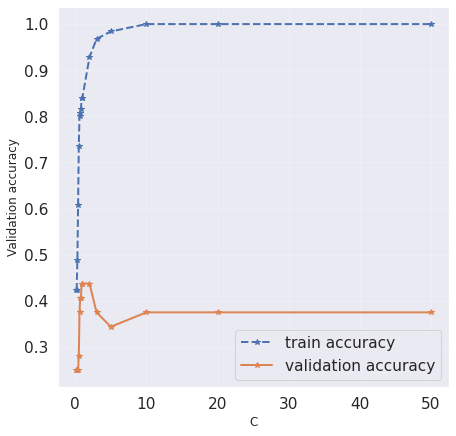

In [ ]:
from google.colab import widgets
from sklearn.metrics import confusion_matrix

# Standardization
mean = X_train.mean(0)
sd =  X_train.std(0)
X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd
C_values =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,5,10,20,50]

# Initialize tabs
tb = widgets.TabBar([str(C) for C in C_values])

accuracy = dict.fromkeys(C_values)
train_accuracy = dict.fromkeys(C_values)
for C in C_values:
  with tb.output_to(str(C), select= (C < 1)):

    # Model Training
    model  = svm.SVC(kernel='rbf',C=float(C),gamma=2)
    model.fit(X_train,y_train)
    
    # Predict using the model for both training and validation data
    yt_p = model.predict(X_train)
    yv_p = model.predict(X_val)
    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))
    accuracy[C] = np.mean(yv_p==y_val)
    train_accuracy[C] = np.mean(yt_p==y_train)
    
    # Generating the confusion matrix    
    trainMatrix = confusion_matrix(y_true=y_train, y_pred=yt_p)
    trainMatrix_nor = trainMatrix.astype('float') / trainMatrix.sum(axis=1)[:, np.newaxis]
    valMatrix = confusion_matrix(y_true=y_val, y_pred=yv_p)
    valMatrix_nor = valMatrix.astype('float') / valMatrix.sum(axis=1)[:, np.newaxis]

    print('Confusion matrix for Training:\n {}\n'.format(trainMatrix))
    print('Confusion matrix for Validation:\n {}\n'.format(valMatrix))

    print('Normalised confusion matrix for Training:\n {}\n'.format(trainMatrix_nor))
    print('Normalised confusion matrix for Validation :\n {}\n'.format(valMatrix_nor))

# Here we predict the value of the validation accuracy as a function of C
plt.figure(figsize=(7, 7))
plt.plot(C_values , list(train_accuracy.values()),'--*',label = 'train accuracy', linewidth=2)
plt.plot(C_values, list(accuracy.values()),'-*',label = 'validation accuracy', linewidth=2)
plt.xlabel("C", fontsize=12)
plt.ylabel("Validation accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc="lower right")
plt.show()

**Observations:** 
Parameter values with C=0.9 and gamma=2 giving the best result

**Confusion Matrix:** 
SVM gave us the best model with gamma = 2 and C = 0.9 giving an the best accuracy among all the models. 

Once again, compare the training and validation accuracies. Do you think this classifier is better than the previous one? What could you do to build a better classifier?

# **ADVANCE SOLUTION**

Advanced solution [10 marks]: Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).

**Data Pre-Processing**

For data processing we encoding the audio file by extracting the pitch. 

Using the fraction of sound region, feature, for calculating the sound duration for each sound bite. 

Calculated for raw format pitch encoded format.


In [ ]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,
                                                 frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag


scale_audio=True
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
len(files)
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')
labels


X,y =[],[]
X_v, X_v_p, y_order = [],[],[]
data_1, data_2,data_3,data_4 = [],[],[],[]
for file in tqdm(files[:500]):
    fileID = file.split('/')[-1]
    yi = list(labels[labels['File ID']==fileID]['digit_label'])[0]
    fs = None # if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio: x = x/np.max(np.abs(x))
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
    voiced_fr = np.mean(voiced_flag)
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)


    # Calculate the sound duration for the sound bite
    x_v_i = voiced_fr*len(x)
    X_v.append(x_v_i)
    # Here we calculate the voiced duration for the pitch encoded sound bite
    x_v_p_i = voiced_fr*len(f0)
    X_v_p.append(x_v_p_i)
    if yi in [0,1,2,3,4,5,6,7,8,9]:
      y_order.append('Ones')
      data_1.append(x_v_i)
    elif yi in [10,11,12,13,14,15,16,17,18,19]:
      y_order.append('Teens')
      data_2.append(x_v_i)
    elif yi in [20,30,40,50,60,70,80,90,100]:
      y_order.append('Tens')
      data_3.append(x_v_i)
    else :
      y_order.append('Hundreds')
      data_4.append(x_v_i)


100%|██████████| 500/500 [02:39<00:00,  3.14it/s]


**Exploratory Data Analysis & Data Visualisation**


*   Calculating the mean sound duration.
*   Remove the outliers
*   Plotting a box plot for the sound duration for the recordings
*   Plotting individual box plot for each numeral range.

(500, 4)
(500,)
The mean sound duration  10649.22742149441
The mean sound duration (pitch encoded) 41.936


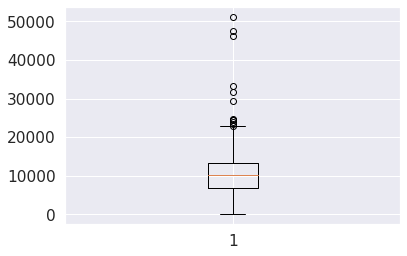

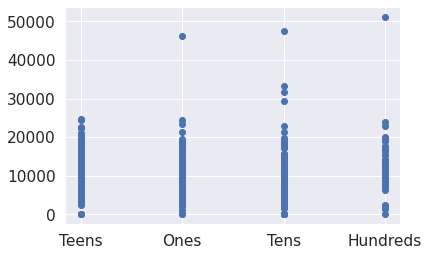

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


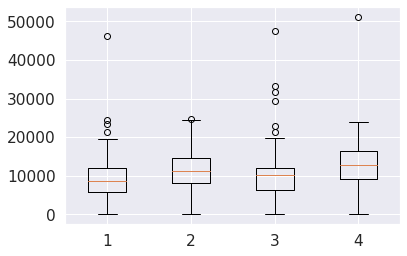

9381.58456418274
11415.625233532282
10397.747980510134
13185.984605644846
The mean voiced duration after removing outliers (pitch encoded) nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
X = np.array(X)
y = np.array(y)
X_v = np.array(X_v)
X_v_p = np.array(X_v_p)
print(X.shape)
print(y.shape)

y_order = np.array(y_order)
mean_sound_duration = np.mean(X_v)
mean_sound_duration_pitch = np.mean(X_v_p)
std_sound_duration_pitch = np.std(X_v_p)
print("The mean sound duration ",mean_sound_duration)
print("The mean sound duration (pitch encoded)",mean_sound_duration_pitch)

# Plotting the Box Plot
plt.boxplot(X_v)
plt.show()

plt.scatter(y_order,X_v)
plt.show()

dataf = [data_1,data_2,data_3,data_4]
plt.boxplot(dataf)
plt.show()
#print(X_fr)
print(sum(data_1)/len(data_1))
print(sum(data_2)/len(data_2))
print(sum(data_3)/len(data_3))
print(sum(data_4)/len(data_4))


# Removed outliers for beyond 2 Standard Deviations
mean_dist = abs(X_fr_p - mean_sound_duration_pitch)
max_deviations = 2
no_outlier = mean_dist < max_deviations * std_sound_duration_pitch
X_v_p_o = X_v_p[no_outlier]

#print(len(X_fr_p_o))

mean_sound_duration_pitch = np.mean(X_v_p_o) 
# After removing outliers
print("The mean voiced duration after removing outliers (pitch encoded)",mean_sound_duration_pitch)

In [ ]:
# Printing the shape of the dataset

print('The shape of X is', X.shape) 
print('The shape of y is', y.shape)
if np.sum(np.isnan(X)):
  idx = np.isnan(X).sum(1)>0
  X = X[~idx]
  y = y[~idx]
print(np.sum(np.isnan(X)))

The shape of X is (500, 4)
The shape of y is (500,)
0


*Dataset Splitting*

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.3)
X_train.shape, X_val.shape, y_train.shape, y_val.shape
#print(y_train)
#print(y_val)

((350, 4), (150, 4), (350,), (150,))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.04857142857142857
Validation  Accuracy 0.013333333333333334
Training confusion matrix:
 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0
   0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.07428571428571429
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 0 0 ... 0 2 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 1 0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.06
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0  7  0]
 [ 0  0  0 ...  0  2  0]
 ...
 [ 0  0  0 ...  0  5  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  2  0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.07428571428571429
Validation  Accuracy 0.04
Training confusion matrix:
 [[ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0  6  0]
 [ 0  0  0 ...  0  1  0]
 ...
 [ 0  0  0 ...  0  3  0]
 [ 0  0  0 ...  0 11  0]
 [ 0  0  0 ...  0  2  0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.08857142857142856
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 0 0 ... 0 3 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 1 0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.08571428571428572
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 3 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.09142857142857143
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 2 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.11142857142857143
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 2 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.11142857142857143
Validation  Accuracy 0.05333333333333334
Training confusion matrix:
 [[0 1 0 ... 0 2 0]
 [0 3 0 ... 0 3 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 3 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 0 2 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.12285714285714286
Validation  Accuracy 0.05333333333333334
Training confusion matrix:
 [[0 1 0 ... 0 2 0]
 [0 3 0 ... 0 3 0]
 [0 0 0 ... 0 1 0]
 ...
 [0 1 0 ... 0 3 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 0]
 [0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 2 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 1 1 0 0 1 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.18
Validation  Accuracy 0.06666666666666667
Training confusion matrix:
 [[0 1 0 ... 0 2 0]
 [0 5 0 ... 0 2 0]
 [0 0 1 ... 0 1 0]
 ...
 [0 3 0 ... 0 2 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 2 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 2 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 1 2 0 0 0 0 0 0 0 0 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.18857142857142858
Validation  Accuracy 0.05333333333333334
Training confusion matrix:
 [[0 1 0 ... 0 2 0]
 [0 4 0 ... 0 1 0]
 [0 0 2 ... 0 1 0]
 ...
 [0 2 0 ... 0 1 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 0]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 2 0]
 [0 1 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 3 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 1 1 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.24571428571428572
Validation  Accuracy 0.06
Training confusion matrix:
 [[0 1 1 ... 0 2 0]
 [0 5 0 ... 0 1 1]
 [1 0 2 ... 0 0 0]
 ...
 [0 3 0 ... 0 1 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 2]]

Validation confusion matrix:
 [[0 0 0 0 0 0 0 0 1 0 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1]
 [0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.2857142857142857
Validation  Accuracy 0.06
Training confusion matrix:
 [[1 1 1 ... 0 2 1]
 [0 4 0 ... 0 1 1]
 [1 0 2 ... 0 0 0]
 ...
 [0 2 0 ... 1 0 0]
 [0 0 0 ... 0 9 0]
 [1 1 0 ... 0 0 3]]

Validation confusion matrix:
 [[0 1 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 1 0 0 0 0 0 1 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.36
Validation  Accuracy 0.05333333333333334
Training confusion matrix:
 [[1 0 1 ... 0 2 1]
 [0 5 0 ... 0 1 1]
 [0 0 3 ... 0 0 0]
 ...
 [0 3 0 ... 2 0 0]
 [0 0 0 ... 0 8 0]
 [0 0 0 ... 0 0 5]]

Validation confusion matrix:
 [[0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1]
 [0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 

<IPython.core.display.Javascript object>

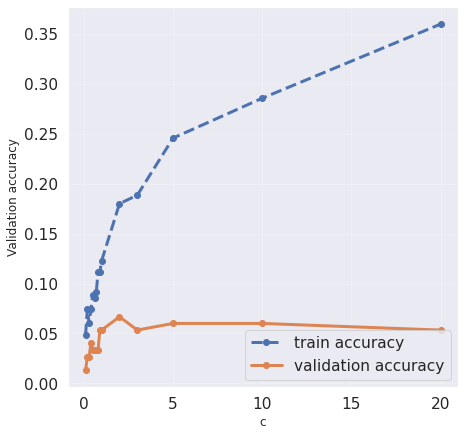

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)

from google.colab import widgets
from sklearn.metrics import confusion_matrix


X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd
C_val =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,2,3,5,10,20]

tb = widgets.TabBar([str(C) for C in C_val])

accuracy = dict.fromkeys(C_val)
train_accuracy = dict.fromkeys(C_val)
for C in C_val:
  with tb.output_to(str(C)):
    
    model  = svm.SVC(C=float(C),gamma=0.1)
    model.fit(X_train,y_train)

    yt_p = model.predict(X_train)
    yv_p = model.predict(X_val)

    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))
    accuracy[C] = np.mean(yv_p==y_val)
    train_accuracy[C] = np.mean(yt_p==y_train)
    
    train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=yt_p)
    train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]
    val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=yv_p)
    val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

    print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
    print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

    print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
    print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

# Here we predict the value of the validation accuracy as a function of k
plt.figure(figsize=(7, 7))
plt.plot(C_val , list(train_accuracy.values()),'--o',label = 'train accuracy', linewidth=3)
plt.plot(C_val, list(accuracy.values()),'-o',label = 'validation accuracy', linewidth=3)
plt.xlabel("c", fontsize=12)
plt.ylabel("Validation accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc="lower right")
plt.show()

**Random Forest Classifier**

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The number of estimators hyper-parameter indicates number of decision trees used.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.6342857142857142
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[ 9  0  0 ...  0  0  0]
 [ 0  8  0 ...  1  0  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  1  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  4]]

Validation confusion matrix:
 [[0 0 0 ... 0 2 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.75       0.         0.         ... 0.         0.         0.        ]
 [0.         0.66666667 0.         ... 0.08333333 0.         0.        ]
 [0.         0.         0.33333333 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.625      0.125      0.        ]
 [0.         0.         0.         ... 0.         0.75       0.        ]
 [0.         0.         0.         ... 0.         0.         0.4       ]]

Normalised validation confusion matrix:
 [[0.         0.         0.         ... 0.         0.4        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.6257142857142857
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[10  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  1  0 ...  3  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0  3]]

Validation confusion matrix:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Normalised training confusion matrix:
 [[0.83333333 0.         0.         ... 0.         0.         0.        ]
 [0.         0.83333333 0.         ... 0.         0.         0.        ]
 [0.         0.         0.66666667 ... 0.         0.         0.        ]
 ...
 [0.         0.125      0.         ... 0.375      0.         0.        ]
 [0.         0.         0.         ... 0.         0.625      0.        ]
 [0.         0.         0.         ... 0.         0.         0.3       ]]

Normalised validation confusion matrix:
 [[0.         0.2        0.         ... 0.         0.         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.76
Validation  Accuracy 0.02
Training confusion matrix:
 [[10  1  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  0  5 ...  0  0  0]
 ...
 [ 0  1  1 ...  4  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0  5]]

Validation confusion matrix:
 [[0 1 0 ... 0 0 0]
 [0 0 1 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.83333333 0.08333333 0.         ... 0.         0.         0.        ]
 [0.         0.91666667 0.         ... 0.         0.         0.        ]
 [0.         0.         0.83333333 ... 0.         0.         0.        ]
 ...
 [0.         0.125      0.125      ... 0.5        0.         0.        ]
 [0.         0.         0.         ... 0.         0.8125     0.        ]
 [0.         0.         0.         ... 0.         0.         0.5       ]]

Normalised validation confusion matrix:
 [[0.         0.2        0.         ... 0.         0.         0.        ]
 [0.         0.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.8485714285714285
Validation  Accuracy 0.02
Training confusion matrix:
 [[10  1  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  1  0 ...  4  1  0]
 [ 0  1  0 ...  0 15  0]
 [ 0  0  0 ...  0  0  6]]

Validation confusion matrix:
 [[0 2 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.83333333 0.08333333 0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.125      0.         ... 0.5        0.125      0.        ]
 [0.         0.0625     0.         ... 0.         0.9375     0.        ]
 [0.         0.         0.         ... 0.         0.         0.6       ]]

Normalised validation confusion matrix:
 [[0.         0.4        0.         ... 0.         0.2        0.        ]
 [0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.8828571428571429
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[10  1  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 1  0  4 ...  0  1  0]
 ...
 [ 0  1  0 ...  6  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0  6]]

Validation confusion matrix:
 [[0 2 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 2 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.83333333 0.08333333 0.         ... 0.         0.         0.        ]
 [0.         0.91666667 0.         ... 0.         0.         0.        ]
 [0.16666667 0.         0.66666667 ... 0.         0.16666667 0.        ]
 ...
 [0.         0.125      0.         ... 0.75       0.         0.        ]
 [0.         0.         0.         ... 0.         0.9375     0.        ]
 [0.         0.         0.         ... 0.         0.         0.6       ]]

Normalised validation confusion matrix:
 [[0.         0.4        0.         ... 0.         0.2        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.9342857142857143
Validation  Accuracy 0.02
Training confusion matrix:
 [[10  0  0 ...  0  1  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  1  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0  8]]

Validation confusion matrix:
 [[0 2 0 ... 0 2 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.83333333 0.         0.         ... 0.         0.08333333 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.75       0.125      0.        ]
 [0.         0.         0.         ... 0.         0.9375     0.        ]
 [0.         0.         0.         ... 0.         0.         0.8       ]]

Normalised validation confusion matrix:
 [[0.         0.4        0.         ... 0.         0.4        0.        ]
 [0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.9514285714285714
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[11  0  0 ...  0  1  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  1  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0  9]]

Validation confusion matrix:
 [[0 2 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[0.91666667 0.         0.         ... 0.         0.08333333 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.75       0.125      0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.9       ]]

Normalised validation confusion matrix:
 [[0.         0.4        0.         ... 0.         0.2        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.96
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[12  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  1  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0  8]]

Validation confusion matrix:
 [[0 2 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[1.     0.     0.     ... 0.     0.     0.    ]
 [0.     1.     0.     ... 0.     0.     0.    ]
 [0.     0.     1.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.75   0.125  0.    ]
 [0.     0.     0.     ... 0.     0.9375 0.    ]
 [0.     0.     0.     ... 0.     0.     0.8   ]]

Normalised validation confusion matrix:
 [[0.         0.4        0.         ... 0.         0.2        0.        ]
 [0.16666667 0.         0.         ... 0.16666667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.98
Validation  Accuracy 0.02666666666666667
Training confusion matrix:
 [[12  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  8  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  0 10]]

Validation confusion matrix:
 [[0 1 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[1.     0.     0.     ... 0.     0.     0.    ]
 [0.     1.     0.     ... 0.     0.     0.    ]
 [0.     0.     1.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 1.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.9375 0.    ]
 [0.     0.     0.     ... 0.     0.     1.    ]]

Normalised validation confusion matrix:
 [[0.         0.2        0.         ... 0.         0.2        0.        ]
 [0.16666667 0.         0.         ... 0.16666667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Training Accuracy 0.9885714285714285
Validation  Accuracy 0.03333333333333333
Training confusion matrix:
 [[12  0  0 ...  0  0  0]
 [ 0 12  0 ...  0  0  0]
 [ 0  0  6 ...  0  0  0]
 ...
 [ 0  0  0 ...  7  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  0 10]]

Validation confusion matrix:
 [[0 1 0 ... 0 1 0]
 [1 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]]

Normalised training confusion matrix:
 [[1.    0.    0.    ... 0.    0.    0.   ]
 [0.    1.    0.    ... 0.    0.    0.   ]
 [0.    0.    1.    ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.875 0.    0.   ]
 [0.    0.    0.    ... 0.    1.    0.   ]
 [0.    0.    0.    ... 0.    0.    1.   ]]

Normalised validation confusion matrix:
 [[0.         0.2        0.         ... 0.         0.2        0.        ]
 [0.16666667 0.         0.         ... 0.16666667 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>

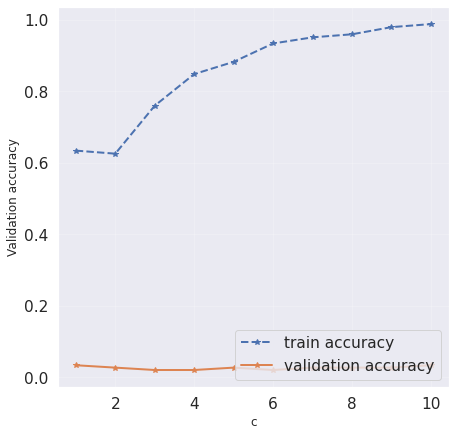

In [ ]:
mean = X_train.mean(0)
sd =  X_train.std(0)


from sklearn.ensemble import RandomForestClassifier


X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd
C_val =[1,2,3,4,5,6,7,8,9,10]


tb = widgets.TabBar([str(C) for C in C_val])

accuracy = dict.fromkeys(C_val)
train_accuracy = dict.fromkeys(C_val)
for C in C_val:
  with tb.output_to(str(C), select= (C < 9)):
    
    model = RandomForestClassifier(n_estimators = C, criterion = 'entropy', random_state = 42)
    model.fit(X_train,y_train)

    yt_p = model.predict(X_train)
    yv_p = model.predict(X_val)

    print('Training Accuracy', np.mean(yt_p==y_train))
    print('Validation  Accuracy', np.mean(yv_p==y_val))
    accuracy[C] = np.mean(yv_p==y_val)
    train_accuracy[C] = np.mean(yt_p==y_train)
    
    train_confusion_matrix = confusion_matrix(y_true=y_train, y_pred=yt_p)
    train_confusion_matrix_normalised = train_confusion_matrix.astype('float') / train_confusion_matrix.sum(axis=1)[:, np.newaxis]
    val_confusion_matrix = confusion_matrix(y_true=y_val, y_pred=yv_p)
    val_confusion_matrix_normalised = val_confusion_matrix.astype('float') / val_confusion_matrix.sum(axis=1)[:, np.newaxis]

    print('Training confusion matrix:\n {}\n'.format(train_confusion_matrix))
    print('Validation confusion matrix:\n {}\n'.format(val_confusion_matrix))

    print('Normalised training confusion matrix:\n {}\n'.format(train_confusion_matrix_normalised))
    print('Normalised validation confusion matrix:\n {}\n'.format(val_confusion_matrix_normalised))

# Here we predict the value of the validation accuracy as a function of number of estimators
plt.figure(figsize=(7, 7))
plt.plot(C_val , list(train_accuracy.values()),'--*',label = 'train accuracy', linewidth=2)
plt.plot(C_val, list(accuracy.values()),'-*',label = 'validation accuracy', linewidth=2)
plt.xlabel("c", fontsize=12)
plt.ylabel("Validation accuracy", fontsize=12)
plt.grid(alpha=0.2)
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

mean = X_train.mean(0)

sd =  X_train.std(0)

X_train = (X_train-mean)/sd
X_val  = (X_val-mean)/sd

classification_models = [
                         SVC(kernel='rbf'),
                         RandomForestClassifier(),
                         
]
scores = []
for model in classification_models:
  model.fit(X_train,y_train)
  score=model.score(X_val,y_val)
  model_name=type(model).__name__
  if model_name=='SVC' and model.kernel=='rbf': model_name='RBF kernel'
  scores.append((model_name,(f'{100*score:.2f}%')))
scores_df = pd.DataFrame(scores,columns=['Model','Accuracy Score'])
scores_df.sort_values(by = 'Accuracy Score',axis = 0, ascending = False)

,Model,Accuracy Score
0,RBF kernel,6.00%
1,RandomForestClassifier,5.33%


**Observation:**
RBF kernel gave the highest validation accuracy of 8.00%

**Conclusion:** 

As can be seen the models that is created gave us a low accuracy :

This issue could be addressed by taking following steps:

*More advance methods like Convolutional Neural Networks might provide better peforming model. This might help in improving the product.*